In [ ]:
!pip install terratorch==0.99.7

In [ ]:
!pip install mega.py

In [ ]:
import os
import sys
import numpy as np
import cv2
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

import terratorch
from terratorch.datamodules import MultiTemporalCropClassificationDataModule
from terratorch.datasets import MultiTemporalCropClassification
from terratorch.tasks import SemanticSegmentationTask
from terratorch.datasets.transforms import FlattenTemporalIntoChannels, UnflattenTemporalFromChannels

import albumentations
from albumentations import Compose, Flip
from albumentations.pytorch import ToTensorV2

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

In [ ]:
if 'google.colab' in sys.modules:
  from mega import Mega
  if not os.path.isfile('multi-temporal-crop-classification.zip'):
    mega = Mega()
    public_link = "https://mega.nz/file/MhZECTbQ#Zs1vKbbMG3TISKB3RAakZ3j-UBUviVdCk_OpMbAxTQY"
    file = mega.download_url(public_link)
    !unzip multi-temporal-crop-classification.zip
  local_path = '.'
else:
  from huggingface_hub import snapshot_download
  local_path = snapshot_download(repo_id='ibm-nasa-geospatial/multi-temporal-crop-classification', repo_type="dataset", cache_dir='.')

In [ ]:
!rm -rf multi-temporal-crop-classification.zip && tar -xvzf datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/training_chips.tgz -C datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/ && \
tar -xvzf datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/validation_chips.tgz -C datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/ && \
mv datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/training_data.txt datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/training_chips/ && \
mv datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/validation_data.txt datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/validation_chips/


## MultiTemporalCrop Example

In [12]:
DATASET_PATH = 'datasets--ibm-nasa-geospatial--multi-temporal-crop-classification/snapshots/04b439f179e52a7b144f69676210eecd30c39cfc/' #os.path.join('~/Documents/', 'multi-temporal-crop-classification')

In [13]:
# those are the recommended transforms for this task
transforms = [
    terratorch.datasets.transforms.FlattenTemporalIntoChannels(),
    albumentations.Flip(),
    albumentations.pytorch.transforms.ToTensorV2(),
    terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
]

In [18]:
# this datamodule allows access to the dataset in its various splits.
datamodule = MultiTemporalCropClassificationDataModule(
    batch_size=16,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    expand_temporal_dimension=True,
)

In [ ]:
# checking for the dataset means and stds
datamodule.means, datamodule.stds

In [ ]:
# checking datasets train split size
datamodule.setup("fit")
train_dataset = datamodule.train_dataset
len(train_dataset)

In [ ]:
# checking datasets available bands
train_dataset.all_band_names

In [ ]:
# checking datasets classes
train_dataset.class_names

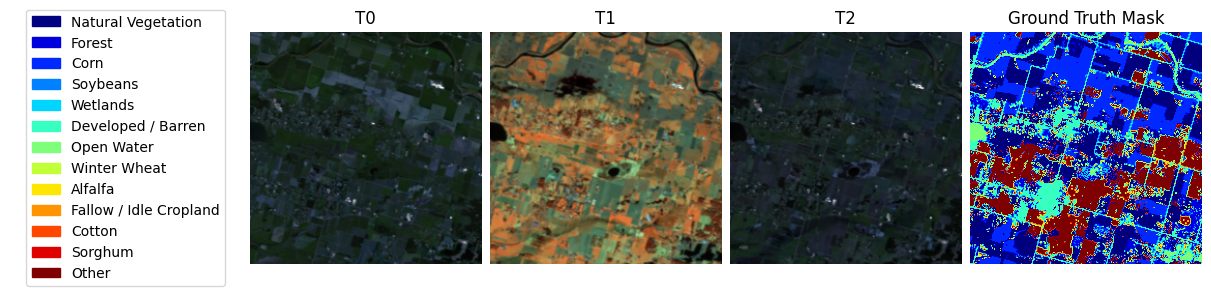

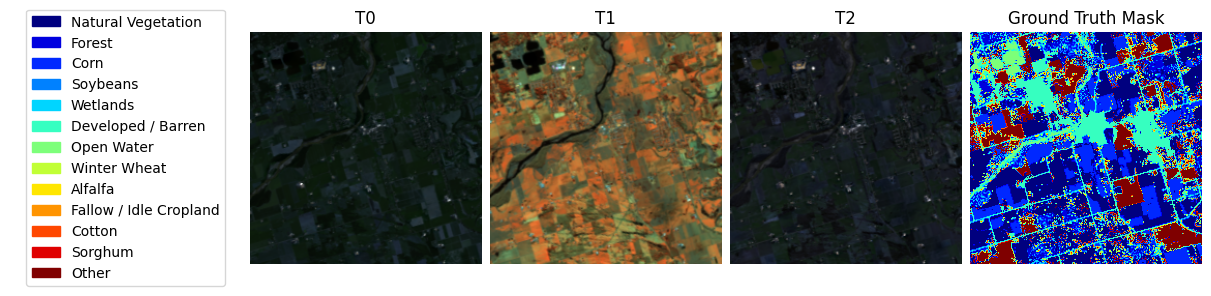

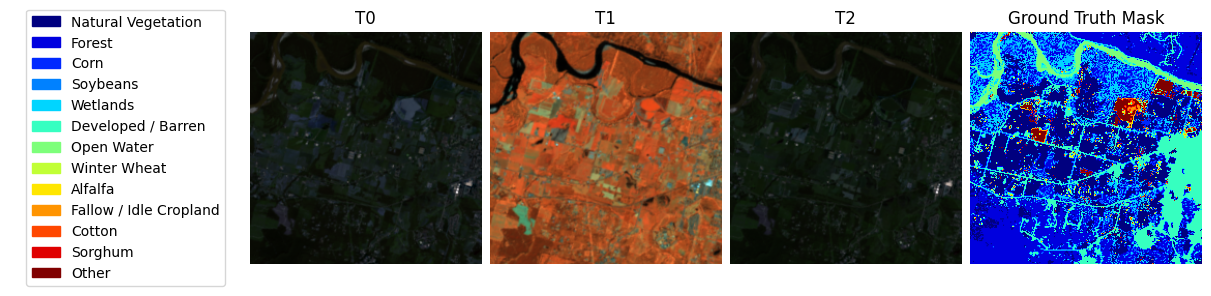

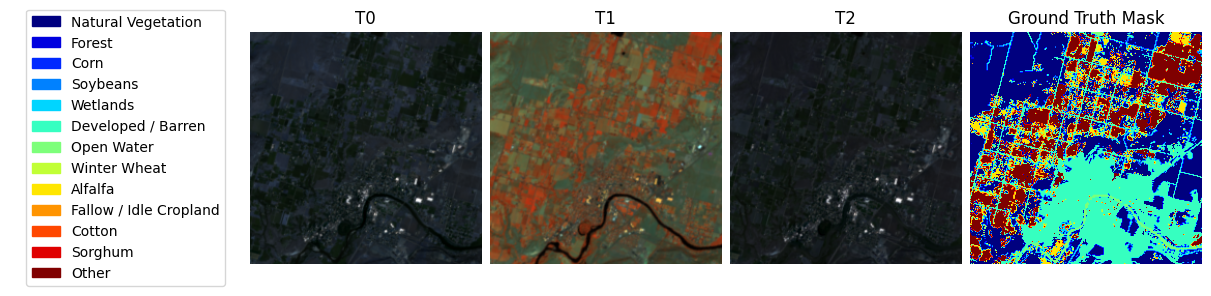

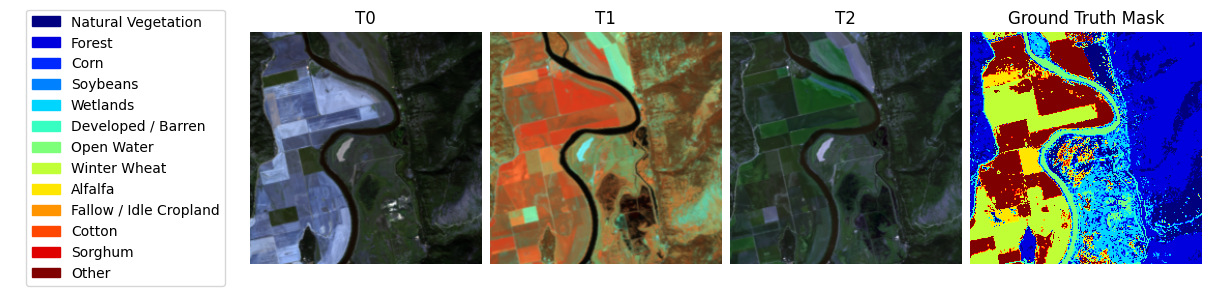

In [23]:
# ploting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [ ]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

In [ ]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

In [ ]:
pl.seed_everything(0)

# Logger
logger = TensorBoardLogger(
    save_dir="output",
    name="tutorial"
)

# colab will kill the kernel after ~24 epochs, therefore stopping after two and pull the correct checkpoint after
max_epochs = 1 if 'google.colab' in sys.modules else 50

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",                 # Directory to save the checkpoints
    mode="max",                             # Maximize variable
    monitor="val/Multiclass_Jaccard_Index", # Variable to monitor
    filename="epoch-{epoch:02d}",           # Filename format
    save_top_k=-1,                          # Save all checkpoints
    every_n_epochs=50,                      # Save every epoch
    save_on_train_epoch_end=True            # Ensure saving after each epoch
)

# Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices="auto",
    num_nodes=1,
    logger = logger,
    max_epochs=max_epochs,
    check_val_every_n_epoch=2,
    log_every_n_steps=10,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
    default_root_dir="root_dir",
)

# DataModule
data_module = MultiTemporalCropClassificationDataModule(
    batch_size=8,
    data_root=DATASET_PATH,
    train_transform=transforms,
    val_transform=transforms,
    test_transform=transforms,
    reduce_zero_label=True,
    expand_temporal_dimension=True,
    use_metadata=False, # Multicropclassification dataset has metadata for location and time
)

# Model
model = SemanticSegmentationTask(
    model_args={
        "decoder": "UperNetDecoder",
        "backbone_pretrained": True,
        "backbone": "prithvi_eo_v2_300_tl", # Model can be either prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl
        "backbone_in_channels": 6,
        "backbone_features_only": True,
        # "backbone_coords_encoding": ["time", "location"], # this must be used to use time and location metadata
        "rescale": True,
        "backbone_bands": ["BLUE", "GREEN", "RED", "NIR_NARROW", "SWIR_1", "SWIR_2"],
        "backbone_num_frames": 3,
        "num_classes": 13,
        "head_dropout": 0.1,
        "decoder_channels": 256,
        "decoder_scale_modules": True,
        "necks": [
            {
                "name": "SelectIndices",
                #"indices": [2, 5, 8, 11] # indices for prithvi_vit_100
                "indices": [5, 11, 17, 23] # indices for prithvi_eo_v2_300
                #"indices": [7, 15, 23, 31] # indices for prithvi_eo_v2_600
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            }
        ]

    },
    plot_on_val=False,
    class_weights=[0.386375, 0.661126, 0.548184, 0.640482, 0.876862, 0.925186, 3.249462, 1.542289, 2.175141, 2.272419, 3.062762, 3.626097, 1.198702],
    loss="ce",
    lr=2.0e-4,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.1},
    ignore_index=-1,
    freeze_backbone=False,
    freeze_decoder=False,
    model_factory="EncoderDecoderFactory",
)

# Training
trainer.fit(model, datamodule=data_module)

In [ ]:
# on colab 50 epochs would run into a timeout (approx. 23 are possible), therefore grabbing a checkpoint from epoch 50
if 'google.colab' in sys.modules:
  import gdown
  if not os.path.isfile('multitemporalcrop.ckpt'):
    gdown.download("https://drive.google.com/uc?id=1Caz9tpdmGe1OdnZ19oI3Ibgg95CPbobq")

In [15]:
trainer.test(model, datamodule=data_module, ckpt_path='multitemporalcrop.ckpt')

INFO: Restoring states from the checkpoint path at multitemporalcrop.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at multitemporalcrop.ckpt
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/call.py:277: Be aware that when using `ckpt_path`, callbacks used to create the checkpoint need to be provided during `Trainer` instantiation. Please add the following callbacks: ["ModelCheckpoint{'monitor': 'val/Multiclass_Jaccard_Index', 'mode': 'max', 'every_n_train_steps': 0, 'every_n_epochs': 1, 'train_time_interval': None}"].
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loaded model weights from the checkpoint at multitemporalcrop.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Loaded model weights from the checkpoint at multitemporalcrop.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃             Test metric             ┃            DataLoader 0             ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test/Multiclass_Accuracy       │         0.6077515482902527          │
│      test/Multiclass_F1_Score       │         0.6077515482902527          │
│    test/Multiclass_Jaccard_Index    │         0.4318826198577881          │
│ test/Multiclass_Jaccard_Index_Micro │         0.43652522563934326         │
│              test/loss              │         1.0382460355758667          │
│      test/multiclassaccuracy_0      │         0.5118498802185059          │
│      test/multiclassaccuracy_1      │         0.5848209261894226          │
│     test/multiclassaccuracy_10      │         0.7194676995277405          │
│     test/multiclassaccuracy_11      │         0.7133731245994568          │
│     test/multiclassaccuracy_12      │         0.5434722304344177          │
│      test/multiclassaccuracy_2      │         0.6216597557067871          │
│      test/multiclassaccuracy_3      │         0.6921235918998718          │
│      test/multiclassaccuracy_4      │         0.6203012466430664          │
│      test/multiclassaccuracy_5      │         0.5744451284408569          │
│      test/multiclassaccuracy_6      │         0.8880362510681152          │
│      test/multiclassaccuracy_7      │         0.6046645045280457          │
│      test/multiclassaccuracy_8      │         0.6311920285224915          │
│      test/multiclassaccuracy_9      │         0.6432090401649475          │
│    test/multiclassjaccardindex_0    │         0.4226419925689697          │
│    test/multiclassjaccardindex_1    │         0.4422249495983124          │
│   test/multiclassjaccardindex_10    │         0.33973559737205505         │
│   test/multiclassjaccardindex_11    │         0.3635536730289459          │
│   test/multiclassjaccardindex_12    │         0.36996886134147644         │
│    test/multiclassjaccardindex_2    │          0.532086968421936          │
│    test/multiclassjaccardindex_3    │          0.521450936794281          │
│    test/multiclassjaccardindex_4    │         0.42691341042518616         │
│    test/multiclassjaccardindex_5    │         0.3440465033054352          │
│    test/multiclassjaccardindex_6    │         0.6589512228965759          │
│    test/multiclassjaccardindex_7    │         0.49981969594955444         │
│    test/multiclassjaccardindex_8    │         0.3295063078403473          │
│    test/multiclassjaccardindex_9    │         0.36357441544532776         │
└─────────────────────────────────────┴─────────────────────────────────────┘

[{'test/loss': 1.0382460355758667,
  'test/Multiclass_Accuracy': 0.6077515482902527,
  'test/multiclassaccuracy_0': 0.5118498802185059,
  'test/multiclassaccuracy_1': 0.5848209261894226,
  'test/multiclassaccuracy_2': 0.6216597557067871,
  'test/multiclassaccuracy_3': 0.6921235918998718,
  'test/multiclassaccuracy_4': 0.6203012466430664,
  'test/multiclassaccuracy_5': 0.5744451284408569,
  'test/multiclassaccuracy_6': 0.8880362510681152,
  'test/multiclassaccuracy_7': 0.6046645045280457,
  'test/multiclassaccuracy_8': 0.6311920285224915,
  'test/multiclassaccuracy_9': 0.6432090401649475,
  'test/multiclassaccuracy_10': 0.7194676995277405,
  'test/multiclassaccuracy_11': 0.7133731245994568,
  'test/multiclassaccuracy_12': 0.5434722304344177,
  'test/Multiclass_F1_Score': 0.6077515482902527,
  'test/Multiclass_Jaccard_Index': 0.4318826198577881,
  'test/multiclassjaccardindex_0': 0.4226419925689697,
  'test/multiclassjaccardindex_1': 0.4422249495983124,
  'test/multiclassjaccardindex_2':

/usr/local/lib/python3.10/dist-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(cached_file, map_location='cpu')


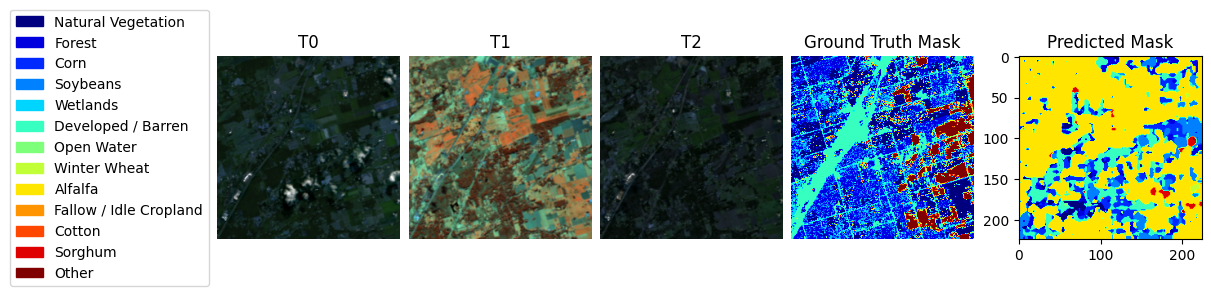

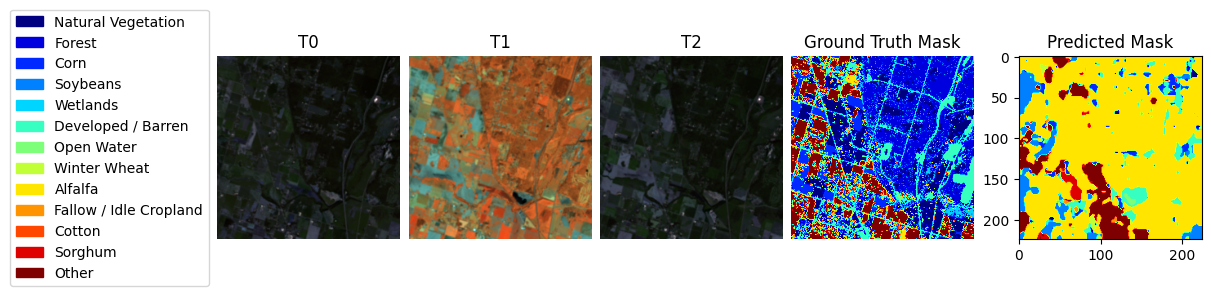

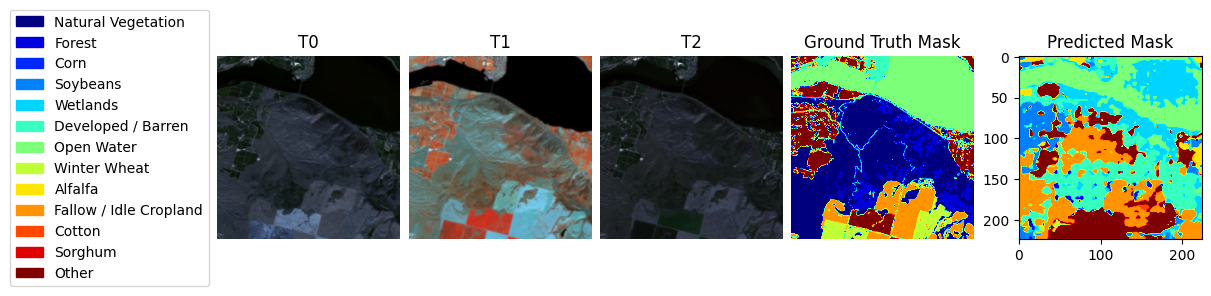

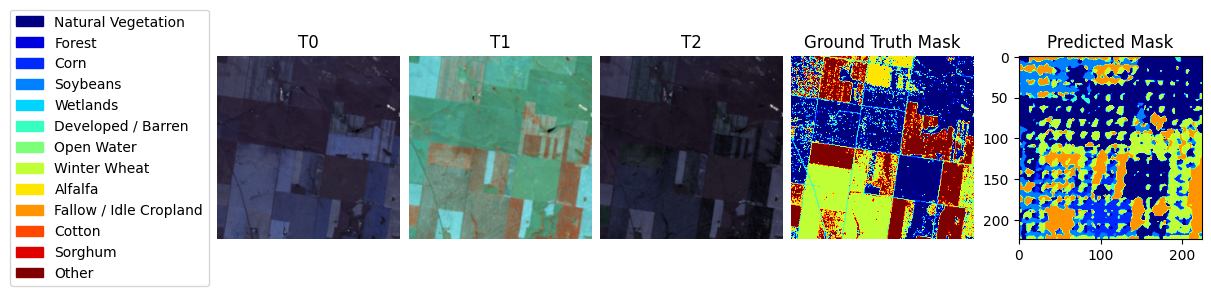

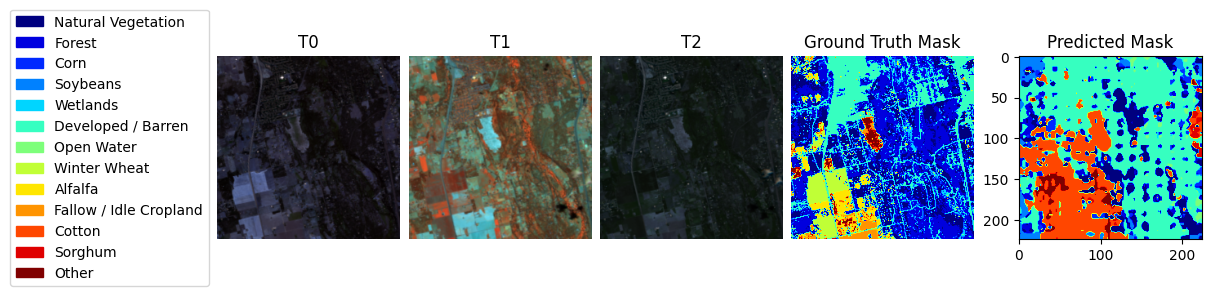

In [26]:
# now we can use the model for predictions and ploting!
best_ckpt_path = 'multitemporalcrop.ckpt'
model = SemanticSegmentationTask.load_from_checkpoint(
    best_ckpt_path,
    model_args=model.hparams.model_args,
    model_factory=model.hparams.model_factory
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = data_module.test_dataloader()
model.to(device)
with torch.no_grad():
    batch = next(iter(test_loader))
    images = batch["image"].to(device)
    masks = batch["mask"].numpy()
    other_keys = batch.keys() - {"image", "mask", "filename"}
    rest = {k: batch[k].to(device) for k in other_keys}

    outputs = model(images, **rest)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

for i in range(5):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[i]
    test_dataset.plot(sample)